# Financial data: Stochastic volatility

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.labelsize': 10, 'font.size': 10, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")

## Step 1: Prepare the data

In [25]:
from pandas_datareader import data
returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Close'].pct_change()
returns.head()

Date
2008-05-01         NaN
2008-05-02    0.002764
2008-05-05   -0.004805
2008-05-06    0.008663
2008-05-07   -0.017811
Name: Close, dtype: float64

In [26]:
type(returns)

pandas.core.series.Series

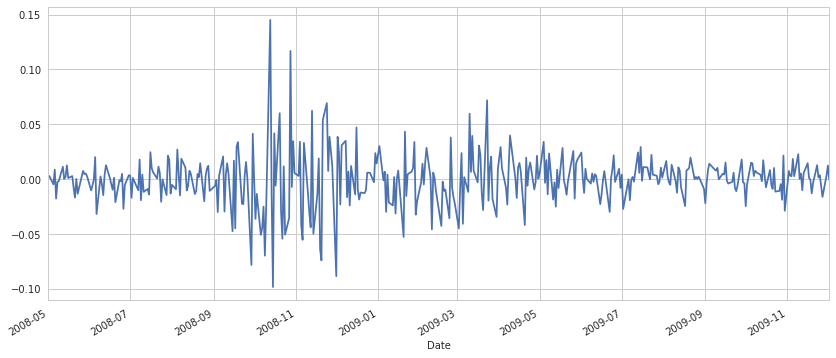

In [27]:
returns.plot()

## Step 2: Build the model

In [28]:
with pm.Model() as returns_model:
    
    # specify the priors
    nu = pm.Exponential("nu", 1/10, testval = 5)
    sigma = pm.Exponential("sigma", 1/0.02, testval = 0.1)
    
    # other parameters
    s = pm.GaussianRandomWalk("s", sigma**-2, shape = len(returns))
    volatility = pm.Deterministic("volatility", pm.math.exp(-2*s))
    
    # specify the likelihood
    r = pm.StudentT("r", nu, lam = 1/volatility, observed = returns)

## Step 3: Sample from the posterior

In [30]:
with returns_model:
    step = pm.NUTS(target_accept = 0.99)
    posterior = pm.sample(draws = 1000, njobs = 1, tune = 500, step = step)

100%|██████████| 1500/1500 [09:54<00:00,  2.52it/s]/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:460: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)

100%|██████████| 1500/1500 [11:11<00:00,  2.23it/s]/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:460: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



## Step 4: Diagnose converge of MCMC chains

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdf945c668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fcdfa5705c0>]], dtype=object)

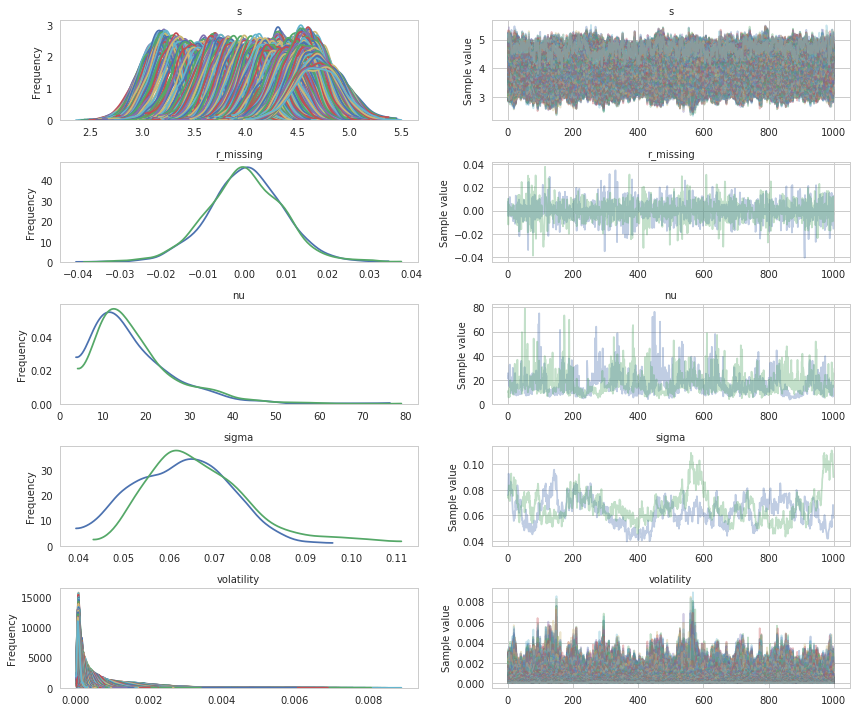

In [31]:
pm.traceplot(posterior)

In [34]:
pm.gelman_rubin(posterior, varnames = ["nu", "r_missing", "sigma"])

{'nu': 1.0010167934071514,
 'r_missing': array([ 0.99961966]),
 'sigma': 1.0384569828876111}

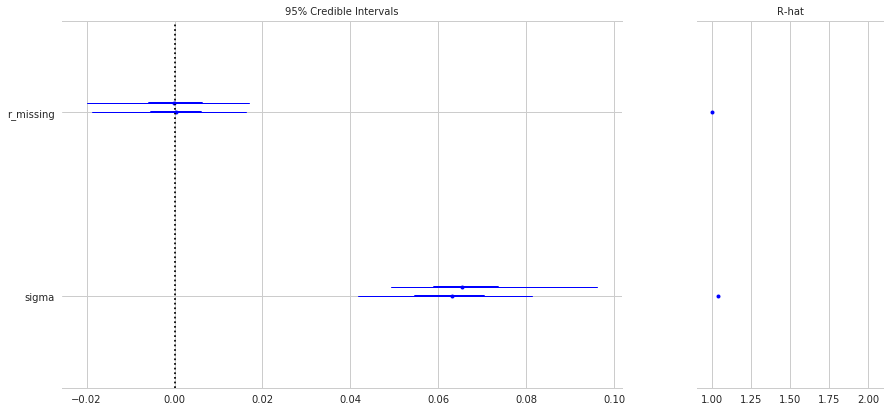

In [39]:
pm.forestplot(posterior, varnames = ["r_missing", "sigma"])

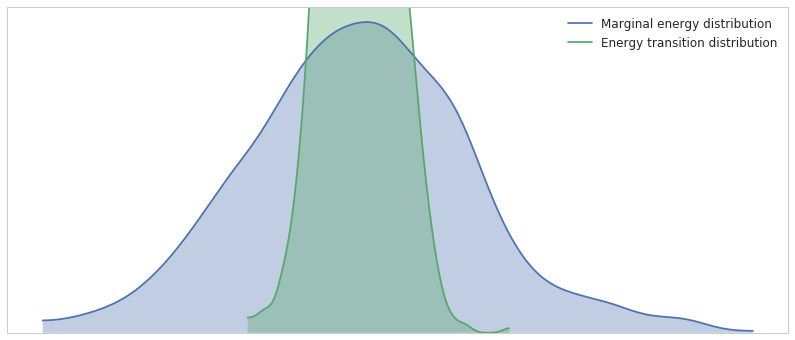

In [36]:
pm.energyplot(posterior)

## Step 5: Criticize the model

In [42]:
pm.summary(posterior, varnames = ["nu", "r_missing", "sigma"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
nu,17.789667,10.177872,0.522411,4.901544,37.377451,241.0,1.001017
r_missing__0,0.000100,0.009265,0.000160,-0.018862,0.017051,2000.0,0.999620
sigma,0.065152,0.011646,0.001021,0.041732,0.086827,27.0,1.038457


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcde6e6d748>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fcde6e5e518>], dtype=object)

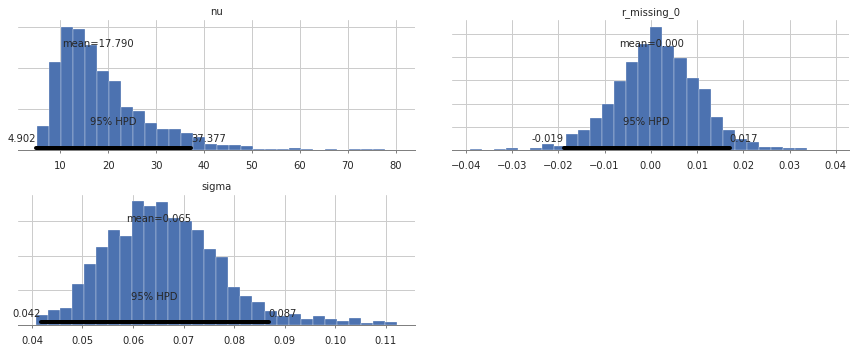

In [41]:
pm.plot_posterior(posterior, varnames = ["nu", "r_missing", "sigma"])